In [ ]:
!git clone https://github.com/ALMSantana/SoccerAlgorithm.git

: 

In [3]:
!cd narya && pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.3 MB 3.4 kB/s 
     |████████████████████████████████| 752.0 MB 7.0 kB/s 
     |████████████████████████████████| 6.6 MB 51.0 MB/s 
     |████████████████████████████████| 377 kB 79.4 MB/s 
     |████████████████████████████████| 4.3 MB 63.0 MB/s 
     |████████████████████████████████| 254 kB 64.4 MB/s 
     |████████████████████████████████| 28.2 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 76.3 MB/s 
     |████████████████████████████████| 7.8 MB 75.0 MB/s 
     |████████████████████████████████| 158 kB 61.3 MB/s 
     |████████████████████████████████| 1.5 MB 62.1 MB/s 
     |████████████████████████████████| 2.0 MB 74.8 MB/s 
     |████████████████████████████████| 41 kB 263 kB/s 
     |████████████████████████████████| 10.4 MB 62.2 MB/s 
     |████████████████████████████████| 68.7 MB 123 kB/s 
     |████████████████████████

In [4]:
!pip3 install --user tensorflow==2.2.0
!pip3 install --user tensorflow-probability==0.11.0
!pip3 install --user dm-sonnet==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import mxnet as mx
import cv2
import numpy as np
import tensorflow as tf
import segmentation_models as sm
import narya.soccer.deep_homo_model
import narya.soccer.field_visualization
import narya.soccer.keypoint_detection_model
import narya.soccer.torch_visualization

In [6]:
import mxnet as mx
import cv2
import numpy as np
import tensorflow as tf
import segmentation_models as sm
import narya.soccer.deep_homo_model
import narya.soccer.field_visualization
import narya.soccer.keypoint_detection_model
import narya.soccer.torch_visualization

sm.set_framework('tf.keras')

RESNET_ARCHI_TF_KERAS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/deep_homo_model_1.h5"
)
RESNET_ARCHI_TF_KERAS_NAME = "deep_homo_model_1.h5"
RESNET_ARCHI_TF_KERAS_TOTAR = False

def _build_homo_preprocessing(input_shape):
    """Builds the preprocessing function for the Deep Homography estimation Model.
    """

    def preprocessing(input_img, **kwargs):

        if len(input_img.shape) == 4:
            print(
                "Only preprocessing single image, we will consider the first one of the batch"
            )
            image = input_img[0]
        else:
            image = input_img

        image = cv2.resize(image, input_shape)
        image = torch_img_to_np_img(
            normalize_single_image_torch(np_img_to_torch_img(image))
        )
        return image

    return preprocessing

def pyramid_layer(
    x, indx, activation="tanh", output_size=8, nb_neurons=[512, 512, 256, 128]
):
    """Fully connected layers to add at the end of a network.
    Arguments:
        x: a tf.keras Tensor as input
        indx: Integer, an index to add to the name of the layers
        activation: String, name of the activation function to add at the end
        output_size: Size of the last layer, number of outputs
        nb_neurons: Size of the Dense layer to add
    Returns:
        output: a tf.keras Tensor as output
    Raises:
    """
    dense_name_base = "full_" + str(indx)
    for indx, neuron in enumerate(nb_neurons):
        x = tf.keras.layers.Dense(
            neuron, name=dense_name_base + str(neuron) + "_" + str(indx)
        )(x)
#     x = tf.keras.layers.Dense(output_size, name=dense_name_base + "output")(x)
    output = tf.keras.layers.Activation(activation)(x)
    return output

def _build_keypoint_preprocessing(input_shape, backbone):
    """Builds the preprocessing function for the Field Keypoint Detector Model.
    """
    sm_preprocessing = sm.get_preprocessing(backbone)

    def preprocessing(input_img, **kwargs):

        to_normalize = False if np.percentile(input_img, 98) > 1.0 else True

        if len(input_img.shape) == 4:
            print(
                "Only preprocessing single image, we will consider the first one of the batch"
            )
            image = input_img[0] * 255.0 if to_normalize else input_img[0] * 1.0
        else:
            image = input_img * 255.0 if to_normalize else input_img * 1.0

        image = cv2.resize(image, input_shape)
        image = sm_preprocessing(image)
        return image

    return preprocessing


def _build_resnet18():
    """Builds a resnet18 model in keras from a .h5 file.
    Arguments:
    Returns:
        a tf.keras.models.Model
    Raises:
    """
    resnet18_path_to_file = tf.keras.utils.get_file(
        RESNET_ARCHI_TF_KERAS_NAME,
        RESNET_ARCHI_TF_KERAS_PATH,
        RESNET_ARCHI_TF_KERAS_TOTAR,
    )

    resnet18 = tf.keras.models.load_model(resnet18_path_to_file)
    resnet18.compile()

    inputs = resnet18.input
    outputs = resnet18.layers[-2].output

    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name="custom_resnet18")


class DeepHomoModel:
    """Class for Keras Models to predict the corners displacement from an image. These corners can then get used 
    to compute the homography.
    Arguments:
        pretrained: Boolean, if the model is loaded pretrained on ImageNet or not
        input_shape: Tuple, shape of the model's input 
    Call arguments:
        input_img: a np.array of shape input_shape
    """

    def __init__(self, pretrained=False, input_shape=(256, 256)):

        self.input_shape = input_shape
        self.pretrained = pretrained

        self.resnet_18 = _build_resnet18()

        inputs = tf.keras.layers.Input((self.input_shape[0], self.input_shape[1], 3))
        x = self.resnet_18(inputs)
        outputs = pyramid_layer(x, 2)
        
        self.model = tf.keras.models.Model(
            
            inputs=[inputs], outputs=outputs, name="DeepHomoPyramidalFull"
        )

        self.preprocessing = _build_homo_preprocessing(input_shape)

    def __call__(self, input_img):

        img = self.preprocessing(input_img)
        corners = self.model.predict(np.array([img]))

        return corners

    def load_weights(self, weights_path):
        try:
            self.model.load_weights(weights_path)
            print("Succesfully loaded weights from {}".format(weights_path))
        except:
            orig_weights = "Randomly"
            print(
                "Could not load weights from {}, weights will be loaded {}".format(
                    weights_path, orig_weights
                )
            )


            
class KeypointDetectorModel:
    """Class for Keras Models to predict the keypoint in an image. These keypoints can then be used to
    compute the homography.
    Arguments:
        backbone: String, the backbone we want to use
        model_choice: The model architecture. ('FPN','Unet','Linknet')
        num_classes: Integer, number of mask to compute (= number of keypoints)
        input_shape: Tuple, shape of the model's input 
    Call arguments:
        input_img: a np.array of shape input_shape
    """

    def __init__(
        self,
        backbone="efficientnetb3",
        model_choice="FPN",
        num_classes=29,
        input_shape=(320, 320),
    ):

        self.input_shape = input_shape
        self.classes = [str(i) for i in range(num_classes)] + ["background"]
        self.backbone = backbone

        n_classes = len(self.classes)
        activation = "softmax"

        if model_choice == "FPN":
            self.model = sm.FPN(
                self.backbone,
                classes=n_classes,
                activation=activation,
                input_shape=(input_shape[0], input_shape[1], 3),
                encoder_weights="imagenet",
            )
        else:
            self.model = None
            print("{} is not used yet".format(model_choice))

        self.preprocessing = _build_keypoint_preprocessing(input_shape, backbone)

    def __call__(self, input_img):

        img = self.preprocessing(input_img)
        pr_mask = self.model.predict(np.array([img]))
        return pr_mask

    def load_weights(self, weights_path):
        try:
            self.model.load_weights(weights_path)
            print("Succesfully loaded weights from {}".format(weights_path))
        except:
            orig_weights = "from Imagenet"
            print(
                "Could not load weights from {}, weights will be loaded {}".format(
                    weights_path, orig_weights
                )
            )

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [7]:
import numpy as np
import math
import matplotlib.patheffects as path_effects
import cv2

from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.pyplot import arrow
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib import colors

from scipy.signal import savgol_filter
from scipy.spatial import Voronoi

from shapely.geometry import Polygon


"""
Football field vizualization function cloned from https://github.com/Friends-of-Tracking-Data-FoTD
with some minor modifications to:
    * add velocity vectors 
    * ball and possession markers
"""

X_SIZE = 105
Y_SIZE = 68

BOX_HEIGHT = (16.5 * 2 + 7.32) / Y_SIZE * 100
BOX_WIDTH = 16.5 / X_SIZE * 100

GOAL = 7.32 / Y_SIZE * 100

GOAL_AREA_HEIGHT = 5.4864 * 2 / Y_SIZE * 100 + GOAL
GOAL_AREA_WIDTH = 5.4864 / X_SIZE * 100

SCALERS = np.array([X_SIZE / 100, Y_SIZE / 100])
pitch_polygon = Polygon(((0, 0), (0, 100), (100, 100), (100, 0)))


def visualize(**images):
    """PLot images in one row.
    Arguments:
        **images: images to plot
    Returns:
        
    Raises:
        
    """
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()


def draw_pitch(dpi=100, pitch_color="#a8bc95"):
    """Sets up field.
    Arguments:
      dpi: Dots per inch in the field
      pitch_color: Color of the field
    Returns:
      fig,axes: matplotlib fig and axes objects.
    Raises:
    """
    fig = plt.figure(figsize=(12.8, 7.2), dpi=dpi)
    fig.patch.set_facecolor(pitch_color)

    axes = fig.add_subplot(1, 1, 1)
    axes.set_axis_off()
    axes.set_facecolor(pitch_color)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)

    axes.set_xlim(0, 100)
    axes.set_ylim(0, 100)

    plt.xlim([-13.32, 113.32])
    plt.ylim([-5, 105])

    fig.tight_layout(pad=3)

    draw_patches(axes)

    return fig, axes


def draw_patches(axes):
    """Draws basic field shapes on an axes
    Arguments:
      axes: matplotlib axes objects.
    Returns:
      axes: matplotlib axes objects.
    Raises:
    """
    # pitch
    axes.add_patch(plt.Rectangle((0, 0), 100, 100, edgecolor="white", facecolor="none"))

    # half-way line
    axes.add_line(plt.Line2D([50, 50], [100, 0], c="w"))

    # penalty areas
    axes.add_patch(
        plt.Rectangle(
            (100 - BOX_WIDTH, (100 - BOX_HEIGHT) / 2),
            BOX_WIDTH,
            BOX_HEIGHT,
            ec="w",
            fc="none",
        )
    )
    axes.add_patch(
        plt.Rectangle(
            (0, (100 - BOX_HEIGHT) / 2), BOX_WIDTH, BOX_HEIGHT, ec="w", fc="none"
        )
    )

    # goal areas
    axes.add_patch(
        plt.Rectangle(
            (100 - GOAL_AREA_WIDTH, (100 - GOAL_AREA_HEIGHT) / 2),
            GOAL_AREA_WIDTH,
            GOAL_AREA_HEIGHT,
            ec="w",
            fc="none",
        )
    )
    axes.add_patch(
        plt.Rectangle(
            (0, (100 - GOAL_AREA_HEIGHT) / 2),
            GOAL_AREA_WIDTH,
            GOAL_AREA_HEIGHT,
            ec="w",
            fc="none",
        )
    )

    # goals
    axes.add_patch(plt.Rectangle((100, (100 - GOAL) / 2), 1, GOAL, ec="w", fc="none"))
    axes.add_patch(plt.Rectangle((0, (100 - GOAL) / 2), -1, GOAL, ec="w", fc="none"))

    # halfway circle
    axes.add_patch(
        Ellipse(
            (50, 50),
            2 * 9.15 / X_SIZE * 100,
            2 * 9.15 / Y_SIZE * 100,
            ec="w",
            fc="none",
        )
    )

    return axes


def draw_frame(
    df,
    t,
    dpi=100,
    fps=20,
    add_vector=False,
    display_num=False,
    display_time=False,
    show_players=True,
    highlight_color=None,
    highlight_player=None,
    shadow_player=None,
    text_color="white",
    flip=False,
    **anim_args
):
    """
    Draws players from time t (in seconds) from a DataFrame df
    """
    fig, ax = draw_pitch(dpi=dpi)

    dfFrame = get_frame(df, t, fps=fps)

    if show_players:
        for pid in dfFrame.index:
            if pid == 0:
                # se for bola
                try:
                    z = dfFrame.loc[pid]["z"]
                except:
                    z = 0
                size = 1.2 + z
                lw = 0.9
                color = "black"
                edge = "white"
                zorder = 100
            else:
                # se for jogador
                size = 3
                lw = 2
                edge = dfFrame.loc[pid]["edgecolor"]

                if pid == highlight_player:
                    color = highlight_color
                else:
                    color = dfFrame.loc[pid]["bgcolor"]
                if dfFrame.loc[pid]["team"] == "attack":
                    zorder = 21
                else:
                    zorder = 20

            ax.add_artist(
                Ellipse(
                    (dfFrame.loc[pid]["x"], dfFrame.loc[pid]["y"]),
                    size / X_SIZE * 100,
                    size / Y_SIZE * 100,
                    edgecolor=edge,
                    linewidth=lw,
                    facecolor=color,
                    alpha=0.8,
                    zorder=zorder,
                )
            )

            if add_vector:

                arrow_length = (
                    math.sqrt(
                        (dfFrame.loc[pid]["dx"] ** 2 + dfFrame.loc[pid]["dy"] ** 2)
                    )
                    * 20
                )
                color_arrow = "white" if pid == 0 else color
                plt.arrow(
                    x=dfFrame.loc[pid]["x"],
                    y=dfFrame.loc[pid]["y"],
                    dx=dfFrame.loc[pid]["dx"] * 20,
                    dy=dfFrame.loc[pid]["dy"] * 20,
                    length_includes_head=True,
                    color=color_arrow,
                    edgecolor=edge,
                    head_width=1,
                    head_length=arrow_length / 4.0,
                )

            try:
                s = str(int(dfFrame.loc[pid]["player_num"]))
            except ValueError:
                s = ""
            text = plt.text(
                dfFrame.loc[pid]["x"],
                dfFrame.loc[pid]["y"],
                s,
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=8,
                color=text_color,
                zorder=22,
                alpha=0.8,
            )

            text.set_path_effects(
                [
                    path_effects.Stroke(linewidth=1, foreground=text_color, alpha=0.8),
                    path_effects.Normal(),
                ]
            )

    return fig, ax, dfFrame


def add_voronoi_to_fig(fig, ax, dfFrame):
    """ Adds a voronoi diagram to the field, according to the players positions
    Arguments:
      fig,ax: matplotlib fig and axes objects.
      dfFrame: pd.DataFrame with player tracking data
    Returns:
      fig,ax: matplotlib fig and axes objects.
      dfFrame: pd.DataFrame with player tracking data
    Raises:
    """
    polygons = {}
    vor, dfVor = calculate_voronoi(dfFrame)
    for index, region in enumerate(vor.regions):
        if not -1 in region:
            if len(region) > 0:
                try:
                    pl = dfVor[dfVor["region"] == index]
                    polygon = Polygon(
                        [vor.vertices[i] for i in region] / SCALERS
                    ).intersection(pitch_polygon)
                    polygons[pl.index[0]] = polygon
                    color = pl["bgcolor"].values[0]
                    x, y = polygon.exterior.xy
                    plt.fill(x, y, c=color, alpha=0.30)
                except IndexError:
                    pass
                except AttributeError:
                    pass

    plt.scatter(dfVor["x"], dfVor["y"], c=dfVor["bgcolor"], alpha=0.2)

    return fig, ax, dfFrame


def calculate_voronoi(dfFrame):
    """ Computes the voronoi diagram for the players positions
    Arguments:
      dfFrame: pd.DataFrame with player tracking data
    Returns:
      vor: Voronoi dataframe (region for each coordinates)
      dfFrame: pd.DataFrame with player tracking data
    Raises:
    """
    dfTemp = dfFrame.copy().drop(0, errors="ignore")

    values = np.vstack(
        (
            dfTemp[["x", "y"]].values * SCALERS,
            [-1000, -1000],
            [+1000, +1000],
            [+1000, -1000],
            [-1000, +1000],
        )
    )

    vor = Voronoi(values)

    dfTemp["region"] = vor.point_region[:-4]

    return vor, dfTemp


def get_frame(df, t, fps=20):
    """Gets the player data from the right frame
    Arguments:
      df: pd.DataFrame with player tracking data
      t: timestamp of the play
      fps: frame per second
    Returns:
      dfFrame: pd.DataFrame with player tracking data from timestamp t
    Raises:
    """
    dfFrame = df.loc[int(t * fps)].set_index("player")
    dfFrame.player_num = dfFrame.player_num.fillna("")
    return dfFrame


def draw_frame_x(df, t, fps, voronoi=True):
    """Draw field, player and voronoi on the same image
    Arguments:
      df: pd.DataFrame with player tracking data
      t: timestamp of the play
      fps: frame per second
      voronoi : If we draw the voronoi diagram or not
    Returns:
      image: Image of the field, players, ball, and eventually voronoi diagram.
    Raises:
    """
    fig, ax, dfFrame = draw_frame(df, t=t, fps=fps, add_vector=True)
    if voronoi:
        fig, ax, dfFrame = add_voronoi_to_fig(fig, ax, dfFrame)
    image = mplfig_to_npimage(fig)
    plt.close()
    return image


def make_animation(df, fps=20, voronoi=True):
    """Makes a clip from the entire dataset
    Arguments:
      df: pd.DataFrame with player tracking data
      fps: frame per second
      voronoi : If we draw the voronoi diagram or not
    Returns:
      clip: mpy Clip object
    Raises:
    """
    # calculated variables
    length = (df.index.max() + 20) / fps
    clip = mpy.VideoClip(
        lambda x: draw_frame_x(df, t=x, fps=fps, voronoi=voronoi), duration=length - 1
    ).set_fps(fps)
    return clip


def draw_line(df_value, t, fps, smooth=True, show=True):
    """ Draw the value function overtime, and add a marker at the wanted frame
    Arguments:
      df_value: pd.Dataframe with the value of each frame
      t: timestamp of the play to mark the value function
      fps: frame per second
      smooth : If we smooth the value function or not
      show: If we show the plot (otherwise return it as an image)
    Returns:
      image, fig,ax: show or image of the plot
    Raises:
    """
    fig = plt.figure(figsize=(19.2, 10.8), dpi=100)
    ax = fig.add_subplot(111)
    if smooth:
        df_value["Value_smooth"] = savgol_filter(df_value["value"], 21, 3)
    else:
        df_value["Value_smooth"] = df_value["value"]
    x = df_value["frame_count"].values
    y = df_value["Value_smooth"].values

    vmin = df_value["Value_smooth"].min()
    vmax = df_value["Value_smooth"].max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap="cool", norm=norm)
    lc.set_array(y)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    fig.colorbar(line, ax=ax)
    ax.scatter(
        df_value.values[int(t * fps)][0],
        df_value.values[int(t * fps)][2],
        color="green",
        marker="o",
        linewidths=4,
    )
    if show:
        return fig, ax
    else:
        image = mplfig_to_npimage(fig)
        plt.close()
        return image


def make_animation_value(df, fps=20):
    """Makes a clip from the entire dataset of the value function
    Arguments:
      df: pd.DataFrame with player tracking data
      fps: frame per second
    Returns:
      clip: mpy Clip object
    Raises:
    """
    # calculated variables
    length = (df.index.max() + 20) / fps
    clip = mpy.VideoClip(
        lambda x: draw_line(df, t=x, fps=fps), duration=length - 1
    ).set_fps(fps)
    return clip


def add_edg_to_fig(fig, ax, edg_map, vmin=None, vmax=None):
    """Adds an edg_map to a field
    Arguments:
      fig,ax : Matplotlib object from draw_frame
      edg_map: edg_map from agent.py
      vmin,vmax : min and max value of the edg_map
    Returns:
      fig,ax: Matplotlib object from draw_frame, with the map on top
      edg_map: edg_map from agent.py
    Raises:
    """
    cmap = "bwr"
    if vmin is None:
        vmin = np.min(edg_map)
    if vmax is None:
        vmax = np.max(edg_map)
    ax = ax.imshow(
        edg_map,
        extent=(0, 100, 0, 100),
        aspect="auto",
        interpolation="mitchell",
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        alpha=0.5,
    )
    cbar = plt.colorbar(ax)
    cbar.set_label("Value")
    return fig, ax, edg_map


def get_color(idx):
    idx = idx * 3
    color = ((17 * idx) % 255, (37 * idx) % 255, (29 * idx) % 255)

    return color


def plot_tracking(image, tlwhs, obj_ids, scores=None, frame_id=0, fps=0.0, ids2=None):
    im = np.ascontiguousarray(np.copy(image))
    im_h, im_w = im.shape[:2]

    text_scale = max(1, image.shape[1] / 1600.0)
    text_thickness = 1 if text_scale > 1.1 else 1
    line_thickness = max(1, int(image.shape[1] / 500.0))

    radius = max(5, int(im_w / 140.0))
    cv2.putText(
        im,
        "frame: %d fps: %.2f num: %d" % (frame_id, fps, len(tlwhs)),
        (0, int(15 * text_scale)),
        cv2.FONT_HERSHEY_PLAIN,
        text_scale,
        (0, 0, 255),
        thickness=2,
    )

    for i, tlwh in enumerate(tlwhs):
        x1, y1, w, h = tlwh
        intbox = tuple(map(int, (x1, y1, x1 + w, y1 + h)))
        obj_id = int(obj_ids[i])
        id_text = "{}".format(int(obj_id))
        if ids2 is not None:
            id_text = id_text + ", {}".format(int(ids2[i]))
        _line_thickness = 1 if obj_id <= 0 else line_thickness
        color = get_color(abs(obj_id))
        cv2.rectangle(
            im, intbox[0:2], intbox[2:4], color=color, thickness=line_thickness
        )
        cv2.putText(
            im,
            id_text,
            (intbox[0], intbox[1] + 30),
            cv2.FONT_HERSHEY_PLAIN,
            text_scale,
            (0, 0, 255),
            thickness=text_thickness,
        )
    return im


def rgb_template_to_coord_conv_template(rgb_template):
    assert isinstance(rgb_template, np.ndarray)
    assert rgb_template.min() >= 0.0
    assert rgb_template.max() <= 1.0
    rgb_template = np.mean(rgb_template, 2)
    x_coord, y_coord = np.meshgrid(
        np.linspace(0, 1, num=rgb_template.shape[1]),
        np.linspace(0, 1, num=rgb_template.shape[0]),
    )
    coord_conv_template = np.stack((rgb_template, x_coord, y_coord), axis=2)
    return coord_conv_template


def merge_template(img, warped_template):
    valid_index = warped_template[:, :, 0] > 0.0
    overlay = (
        img[valid_index].astype("float32")
        + warped_template[valid_index].astype("float32")
    ) / 2
    new_image = np.copy(img)
    new_image[valid_index] = overlay
    return new_image


def denormalize(x):
    """Scale image to range [0,1]
    Arguments:
        x: np.array, an image
    Returns:
        x: np.array, the scaled image
    Raises:
    """
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return 

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import kornia
import torch
import cv2


"""
Torch warping function cloned from https://github.com/vcg-uvic/sportsfield_release
with some minor modifications
"""


def normalize_homo(h, **kwargs):
    """Normalize an homography by setting the last coefficient to 1.0
    Arguments:
        h: np.array of shape (3,3), the homography
    Returns:
        A np.array of shape (3,3) representing the normalized homography
    Raises:
        
    """
    return h / h[2, 2]


def horizontal_flip_homo(h, **kwargs):
    """Apply a horizontal flip to the homography
    Arguments:
        h: np.array of shape (3,3), the homography
    Returns:
        A np.array of shape (3,3) representing the horizontally flipped homography
    Raises:
        
    """
    flipper = np.array([[-1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    return np.matmul(h, flipper)


def vertical_flip_homo(h, **kwargs):
    """Apply a vertical flip to the homography
    Arguments:
        h: np.array of shape (3,3), the homography
    Returns:
        A np.array of shape (3,3) representing the vertically flipped homography
    Raises:
        
    """
    flipper = np.array([[1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, 1.0]])
    return np.matmul(h, flipper)


def get_perspective_transform_torch(src, dst):
    """Get the homography matrix between src and dst
    Arguments:
        src: Tensor of shape (B,4,2), the four original points per image
        dst: Tensor of shape (B,4,2), the four corresponding points per image
    Returns:
        A tensor of shape (B,3,3), each homography per image
    Raises:
    """
    return kornia.get_perspective_transform(src, dst)


def get_perspective_transform_cv(src, dst):
    """Get the homography matrix between src and dst
    Arguments:
        src: np.array of shape (B,X,2) or (X,2), the X>3 original points per image
        dst: np.array of shape (B,X,2) or (X,2), the X>3 corresponding points per image
    Returns:
        M: np.array of shape (B,3,3) or (3,3), each homography per image
    Raises:
    """
    if len(src.shape) == 2:
        M, _ = cv2.findHomography(src, dst, cv2.RANSAC, 5)
    else:
        M = []
        for src_, dst_ in zip(src, dst):
            M.append(cv2.findHomography(src_, dst_, cv2.RANSAC, 5)[0])
        M = np.array(M)
    return M


def get_perspective_transform(src, dst, method="cv"):
    """Get the homography matrix between src and dst
    Arguments:
        src: Matrix of shape (B,X,2) or (X,2), the X>3 original points per image
        dst: Matrix of shape (B,X,2) or (X,2), the X>3 corresponding points per image
        method: String in {'cv','torch'} to choose which function to use
    Returns:
        M: Matrix of shape (B,3,3) or (3,3), each homography per image
    Raises:
    """
    return (
        get_perspective_transform_cv(src, dst)
        if method == "cv"
        else get_perspective_transform_torch(src, dst)
    )


def warp_image(img, H, out_shape=None, method="cv"):
    """Apply an homography to a Matrix
    Arguments:
        img: Matrix of shape (B,C,H,W) or (C,H,W)
        H: Matrix of shape (B,3,3) or (3,3), the homography
        out_shape: Tuple, the wanted shape of the out image
        method: String in {'cv','torch'} to choose which function to use
    Returns:
        A Matrix of shape (B) x (out_shape) or (B) x (img.shape), the warped image 
    Raises:
        ValueError: If img and H batch sizes are different
    """
    return (
        warp_image_cv(img, H, out_shape=out_shape)
        if method == "cv"
        else warp_image_torch(img, H, out_shape=out_shape)
    )


def warp_image_torch(img, H, out_shape=None):
    """Apply an homography to a torch Tensor
    Arguments:
        img: Tensor of shape (B,C,H,W) or (C,H,W)
        H: Tensor of shape (B,3,3) or (3,3), the homography
        out_shape: Tuple, the wanted shape of the out image
    Returns:
        A Tensor of shape (B) x (out_shape) or (B) x (img.shape), the warped image 
    Raises:
        ValueError: If img and H batch sizes are different
    """
    if out_shape is None:
        out_shape = img.shape[-2:]
    if len(img.shape) < 4:
        img = img[None]
    if len(H.shape) < 3:
        H = H[None]
    if img.shape[0] != H.shape[0]:
        raise ValueError(
            "batch size of images ({}) do not match the batch size of homographies ({})".format(
                img.shape[0], H.shape[0]
            )
        )
    batchsize = img.shape[0]
    # create grid for interpolation (in frame coordinates)

    y, x = torch.meshgrid(
        [
            torch.linspace(-0.5, 0.5, steps=out_shape[-2]),
            torch.linspace(-0.5, 0.5, steps=out_shape[-1]),
        ]
    )
    x = x.to(img.device)
    y = y.to(img.device)
    x, y = x.flatten(), y.flatten()

    # append ones for homogeneous coordinates
    xy = torch.stack([x, y, torch.ones_like(x)])
    xy = xy.repeat([batchsize, 1, 1])  # shape: (B, 3, N)
    # warp points to model coordinates
    xy_warped = torch.matmul(H, xy)  # H.bmm(xy)
    xy_warped, z_warped = xy_warped.split(2, dim=1)

    # we multiply by 2, since our homographies map to
    # coordinates in the range [-0.5, 0.5] (the ones in our GT datasets)
    xy_warped = 2.0 * xy_warped / (z_warped + 1e-8)
    x_warped, y_warped = torch.unbind(xy_warped, dim=1)
    # build grid
    grid = torch.stack(
        [
            x_warped.view(batchsize, *out_shape[-2:]),
            y_warped.view(batchsize, *out_shape[-2:]),
        ],
        dim=-1,
    )

    # sample warped image
    warped_img = torch.nn.functional.grid_sample(
        img, grid, mode="bilinear", padding_mode="zeros"
    )

    if hasnan(warped_img):
        print("nan value in warped image! set to zeros")
        warped_img[isnan(warped_img)] = 0

    return warped_img


def warp_image_cv(img, H, out_shape=None):
    """Apply an homography to a np.array
    Arguments:
        img: np.array of shape (B,H,W,C) or (H,W,C)
        H: Tensor of shape (B,3,3) or (3,3), the homography
        out_shape: Tuple, the wanted shape of the out image
    Returns:
        A np.array of shape (B) x (out_shape) or (B) x (img.shape), the warped image 
    Raises:
        ValueError: If img and H batch sizes are different
    """
    if out_shape is None:
        out_shape = img.shape[-3:-1] if len(img.shape) == 4 else img.shape[:-1]
    if len(img.shape) == 3:
        return cv2.warpPerspective(img, H, dsize=out_shape)
    else:
        if img.shape[0] != H.shape[0]:
            raise ValueError(
                "batch size of images ({}) do not match the batch size of homographies ({})".format(
                    img.shape[0], H.shape[0]
                )
            )
        out_img = []
        for img_, H_ in zip(img, H):
            out_img.append(cv2.warpPerspective(img_, H_, dsize=out_shape))
        return np.array(out_img)


def warp_point(pts, homography, method="cv"):
    return (
        warp_point_cv(pts, homography)
        if method == "cv"
        else warp_point_torch(pts, homography)
    )


def warp_point_cv(pts, homography):
    dst = cv2.perspectiveTransform(np.array(pts).reshape(-1, 1, 2), homography)
    return dst[0][0]


def warp_point_torch(pts, homography, input_shape = (320,320,3)):
    img_test = np.zeros(input_shape)
    dir_ = [0, -1, 1, -2, 2, 3, -3]
    for dir_x in dir_:
        for dir_y in dir_:
            to_add_x = min(max(0, pts[0] + dir_x), input_shape[0]-1)
            to_add_y = min(max(0, pts[1] + dir_y), input_shape[1]-1)
            for i in range(3):
                img_test[to_add_y, to_add_x, i] = 1.0

    pred_warp = warp_image(
        np_img_to_torch_img(img_test), to_torch(homography), method="torch"
    )
    pred_warp = torch_img_to_np_img(pred_warp[0])
    indx = np.argwhere(pred_warp[:, :, 0] > 0.8)
    x, y = indx[:, 0].mean(), indx[:, 1].mean()
    dst = np.array([y, x])
    return dst


def get_default_corners(batch_size):
    """Get coordinates of the default corners in a soccer field
    Arguments:
        batch_size: Integer, the number of time we need the corners
    Returns:
        orig_corners: a np.array of len(batch_size)
    Raises:
        
    """
    orig_corners = np.array(
        [[-0.5, 0.1], [-0.5, 0.5], [0.5, 0.5], [0.5, 0.1]], dtype=np.float32
    )
    orig_corners = np.tile(orig_corners, (batch_size, 1, 1))
    return orig_corners


def get_corners_from_nn(batch_corners_pred):
    """Gets the corners in the right shape, from a DeepHomoModel
    Arguments:
        batch_corners_pred: np.array of shape (B,8) with the predictions
    Returns:
        corners: np.array of shape (B,4,2) with the corners in the right shape
    Raises:
        
    """
    batch_size = batch_corners_pred.shape[0]
    corners = np.reshape(batch_corners_pred, (-1, 2, 4))
    corners = np.transpose(corners, axes=(0, 2, 1))
    corners = np.reshape(corners, (batch_size, 4, 2))
    return corners


def compute_homography(batch_corners_pred):
    """Compute the homography from the predictions of DeepHomoModel
    Arguments:
        batch_corners_pred: np.array of shape (B,8) with the predictions
    Returns:
        np.array of shape (B,3,3) with the homographies
    Raises:
        
    """
    batch_size = batch_corners_pred.shape[0]
    corners = get_corners_from_nn(batch_corners_pred)
    orig_corners = get_default_corners(batch_size)
    homography = get_perspective_transform_torch(
        to_torch(orig_corners), to_torch(corners)
    )
    return to_numpy(homography)


def get_four_corners(homo_mat):
    """Inverse operation of compute_homography. Gets the 4 corners from an homography.
    Arguments:
        homo_mat: Matrix of shape (B,3,3) or (3,3), homographies
    Returns:
        xy_warped: np.array of shape (B,4,2) with the corners
    Raises:
        ValueError: If the homographies are not of shape (3,3)
    """
    if isinstance(homo_mat, np.ndarray):
        homo_mat = to_torch(homo_mat)

    if homo_mat.shape == (3, 3):
        homo_mat = homo_mat[None]
    if homo_mat.shape[1:] != (3, 3):
        raise ValueError(
            "The shape of the homography is {}, not (3,3)".format(homo_mat.shape[1:])
        )

    canon4pts = to_torch(
        np.array([[-0.5, 0.1], [-0.5, 0.5], [0.5, 0.5], [0.5, 0.1]], dtype=np.float32)
    )

    assert canon4pts.shape == (4, 2)
    x, y = canon4pts[:, 0], canon4pts[:, 1]
    xy = torch.stack([x, y, torch.ones_like(x)])
    # warp points to model coordinates
    xy_warped = torch.matmul(homo_mat, xy)  # H.bmm(xy)
    xy_warped, z_warped = xy_warped.split(2, dim=1)
    xy_warped = xy_warped / (z_warped + 1e-8)
    xy_warped = to_numpy(xy_warped)
    return xy_warped

In [9]:
def torch_img_to_np_img(torch_img):
    """Convert a torch image to a numpy image
    Arguments:
        torch_img: Tensor of shape (B,C,H,W) or (C,H,W)
    Returns:
        a np.array of shape (B,H,W,C) or (H,W,C)
    Raises:
        ValueError: If this is not a Torch tensor
    """
    if isinstance(torch_img, np.ndarray):
        return torch_img
    assert isinstance(torch_img, torch.Tensor), "cannot process data type: {0}".format(
        type(torch_img)
    )
    if len(torch_img.shape) == 4 and (
        torch_img.shape[1] == 3 or torch_img.shape[1] == 1
    ):
        return np.transpose(torch_img.detach().cpu().numpy(), (0, 2, 3, 1))
    if len(torch_img.shape) == 3 and (
        torch_img.shape[0] == 3 or torch_img.shape[0] == 1
    ):
        return np.transpose(torch_img.detach().cpu().numpy(), (1, 2, 0))
    elif len(torch_img.shape) == 2:
        return torch_img.detach().cpu().numpy()
    else:
        raise ValueError("cannot process this image")


def np_img_to_torch_img(np_img):
    """Convert a np image to a torch image
    Arguments:
        np_img: a np.array of shape (B,H,W,C) or (H,W,C)
    Returns:
        a Tensor of shape (B,C,H,W) or (C,H,W)
    Raises:
        ValueError: If this is not a np.array
    """
    if isinstance(np_img, torch.Tensor):
        return np_img
    assert isinstance(np_img, np.ndarray), "cannot process data type: {0}".format(
        type(np_img)
    )
    if len(np_img.shape) == 4 and (np_img.shape[3] == 3 or np_img.shape[3] == 1):
        return to_torch(np.transpose(np_img, (0, 3, 1, 2)))
    if len(np_img.shape) == 3 and (np_img.shape[2] == 3 or np_img.shape[2] == 1):
        return to_torch(np.transpose(np_img, (2, 0, 1)))
    elif len(np_img.shape) == 2:
        return to_torch(np_img)
    else:
        raise ValueError("cannot process this image")


def normalize_single_image_torch(image, img_mean=None, img_std=None):
    """Normalize a Torch tensor
    Arguments:
        image: Torch Tensor of shape (C,W,H)
        img_mean: List of mean per channel (e.g.: [0.485, 0.456, 0.406])
        img_std: List of std per channel (e.g.: [0.229, 0.224, 0.225])
    Returns:
        image: Torch Tensor of shape (C,W,H), the normalized image
    Raises:
        ValueError: If the shape of the image is not of lenth 3
        ValueError: If the image is not a torch Tensor
    """
    if len(image.shape) != 3:
        raise ValueError(
            "The len(shape) of the image is {}, not 3".format(len(image.shape))
        )
    if isinstance(image, torch.Tensor) == False:
        raise ValueError("The image is not a torch Tensor")
    if img_mean is None and img_std is None:
        img_mean = torch.mean(image, dim=(1, 2)).view(-1, 1, 1)
        img_std = image.contiguous().view(image.size(0), -1).std(-1).view(-1, 1, 1)
        image = (image - img_mean) / img_std
    else:
        image = Normalize(img_mean, img_std, inplace=False)(image)
    return image


def denormalize(x):
    """Scale image to range [0,1]
    Arguments:
        x: np.array, an image
    Returns:
        x: np.array, the scaled image
    Raises:
    """
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def to_numpy(var):
    """Parse a Torch variable to a numpy array
    Arguments:
        var: torch variable
    Returns:
        a np.array with the same value as var
    Raises:
        
    """
    try:
        return var.numpy()
    except:
        return var.detach().numpy()


def to_torch(np_array):
    """Parse a numpy array to a torch variable
    Arguments:
        np_array: a np.array 
    Returns:
        a torch Var with the same value as the np_array
    Raises:
        
    """
    tensor = torch.from_numpy(np_array).float()
    return torch.autograd.Variable(tensor, requires_grad=False)
import six
import numpy as np

FLIP_MAPPER = {
    0: 13,
    1: 14,
    2: 15,
    3: 16,
    4: 17,
    5: 18,
    6: 19,
    7: 20,
    8: 21,
    9: 22,
    10: 10,
    11: 11,
    12: 12,
    13: 0,
    14: 1,
    15: 2,
    16: 3,
    17: 4,
    18: 5,
    19: 6,
    20: 7,
    21: 8,
    22: 9,
    23: 27,
    24: 28,
    25: 25,
    26: 26,
    27: 23,
    28: 24,
}


def _get_flip_mapper():
    return FLIP_MAPPER


INIT_HOMO_MAPPER = {
    0: [3, 3],
    1: [3, 66],
    2: [51, 65],
    3: [3, 117],
    4: [17, 117],
    5: [3, 203],
    6: [17, 203],
    7: [3, 255],
    8: [51, 254],
    9: [3, 317],
    10: [160, 3],
    11: [160, 160],
    12: [160, 317],
    13: [317, 3],
    14: [317, 66],
    15: [270, 66],
    16: [317, 118],
    17: [304, 118],
    18: [317, 203],
    19: [304, 203],
    20: [317, 255],
    21: [271, 255],
    22: [317, 317],
    23: [51, 128],
    24: [51, 193],
    25: [161, 118],
    26: [161, 203],
    27: [270, 128],
    28: [269, 192],
}


def _get_init_homo_mapper():
    return INIT_HOMO_MAPPER


def _flip_keypoint(id_kp, x_kp, y_kp, input_shape=(320, 320, 3)):
    """Flip the keypoints verticaly, according to the shape of the image
    Arguments:
        id_kep: Integer, the id of the keypoint
        x_kp, y_kp: the x,y coordinates of the keypoint
        input_shapes: Tuple, the shape of the image concerned with the keypoint
    Returns:
        new_id_kp, x_kp, new_y_kp: Tuple of integer with the flipped id and coordinates
    Raises:
        ValueError: If the id_kp is not in the list of Id
        ValueError: If the y coordinates is larger than the input_shape, or smaller than 0
    """

    if id_kp not in FLIP_MAPPER.keys():
        raise ValueError("Keypoint id {} not in the flip mapper".format(id_kp))
    if y_kp < 0 or y_kp > input_shape[0] - 1:
        raise ValueError(
            "y_kp = {}, outside of range [0,{}]".format(y_kp, input_shape[0] - 1)
        )

    new_id_kp = FLIP_MAPPER[id_kp]
    new_y_kp = input_shape[0] - 1 - y_kp

    return (new_id_kp, x_kp, new_y_kp)


def _add_mask(mask, val, x, y):
    """Takes a mask, and add a new segmentation with the value val, around the (x,y) coordinates
    Arguments:
        mask: np.array, the mask
        val: The value to add to the mask 
        x,y: the coordinates of the segmentation to add
    Returns:
        
    Raises:
        
    """
    dir_x = [0, -1, 1]
    dir_y = [0, -1, 1]
    for d_x in dir_x:
        for d_y in dir_y:
            new_x = min(max(x + d_x, 0), mask.shape[0]-1)
            new_y = min(max(y + d_y, 0), mask.shape[1]-1)
            mask[new_x][new_y] = val


def _build_mask(keypoints, mask_shape=(320, 320), nb_of_mask=29):
    """From a dict of keypoints, creates a list of mask with keypoint segmentation
    Arguments:
        keypoints: Dict, mapping each keypoint id to its location
        mask_shape: Shape of the mask to be created
        nb_of_mask: Number of mask to create (= number of different keypoints)
    Returns:
        mask: np.array of shape (nb_of_mask) x (mask_shape)
    Raises:
    """
    mask = np.ones((mask_shape)) * nb_of_mask
    for id_kp, v in six.iteritems(keypoints):
        _add_mask(mask, id_kp, v[0], v[1])
    return mask


def _get_keypoints_from_mask(mask, treshold=0.9):
    """From a list of mask, compute the mapping of each keypoints to their location
    Arguments:
        mask: np.array of shape (nb_of_mask) x (mask_shape)
        treshold: Treshold of intensity to decide if a pixels is considered or not
    Returns:
        keypoints: Dict, mapping each keypoint id to its location
    Raises:
        
    """
    keypoints = {}
    indexes = np.argwhere(mask[:, :, :-1] > treshold)
    for indx in indexes:
        id_kp = indx[2]
        if id_kp in keypoints.keys():
            keypoints[id_kp][0].append(indx[0])
            keypoints[id_kp][1].append(indx[1])
        else:
            keypoints[id_kp] = [[indx[0]], [indx[1]]]

    for id_kp in keypoints.keys():
        mean_x = np.mean(np.array(keypoints[id_kp][0]))
        mean_y = np.mean(np.array(keypoints[id_kp][1]))
        keypoints[id_kp] = [mean_y, mean_x]
    return keypoints

def collinear(p0, p1, p2, epsilon=0.001):
    x1, y1 = p1[0] - p0[0], p1[1] - p0[1]
    x2, y2 = p2[0] - p0[0], p2[1] - p0[1]
    return abs(x1 * y2 - x2 * y1) < epsilon

def _points_from_mask(mask, treshold=0.9):
    """From a list of mask, compute src and dst points from the image and the 2D view of the image
    Arguments:
        mask: np.array of shape (nb_of_mask) x (mask_shape)
        treshold: Treshold of intensity to decide if a pixels is considered or not
    Returns:
        src_pts, dst_pts: Location of src and dst related points
    Raises:
        
    """
    list_ids = []
    src_pts, dst_pts = [], []
    available_keypoints = _get_keypoints_from_mask(mask, treshold)
    for id_kp, v in six.iteritems(available_keypoints):
        src_pts.append(v)
        dst_pts.append(INIT_HOMO_MAPPER[id_kp])
        list_ids.append(id_kp)
    src, dst = np.array(src_pts), np.array(dst_pts)

    ### Final test : return nothing if 3 points are colinear and the src has just 4 points 
    test_colinear = False
    if len(src) == 4:
        if collinear(dst_pts[0], dst_pts[1], dst_pts[2]) or collinear(dst_pts[0], dst_pts[1], dst_pts[3]) or collinear(dst_pts[1], dst_pts[2], dst_pts[3]) :
          test_colinear = True
    src = np.array([]) if test_colinear else src
    dst = np.array([]) if test_colinear else dst
    
    return src, dst

In [53]:
import cv2
image_path = '/content/SoccerAlgorithm/test_img/print12.jpg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Image shape: (449, 799, 3)


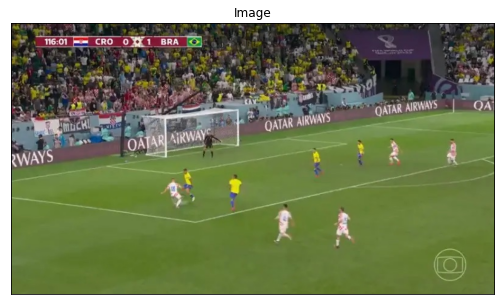

In [54]:
from SoccerAlgorithm.narya.models.gluon_models import TrackerModel
from SoccerAlgorithm.narya.utils.vizualization import visualize
from gluoncv.utils import viz
import tensorflow as tf
print("Image shape: {}".format(image.shape))
visualize(image=image)

In [58]:
from keras.applications import Xception
kp_model = KeypointDetectorModel(
    backbone='efficientnetb3', num_classes=29, input_shape=(320, 320),
)

WEIGHTS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/keypoint_detector.h5"
)
WEIGHTS_NAME = "keypoint_detector.h5"
WEIGHTS_TOTAR = True

checkpoints = tf.keras.utils.get_file(
                WEIGHTS_NAME, WEIGHTS_PATH, WEIGHTS_TOTAR,
            )

kp_model.load_weights(checkpoints)

pr_mask = kp_model(image)

Could not load weights from /root/.keras/datasets/keypoint_detector.h5, weights will be loaded from Imagenet


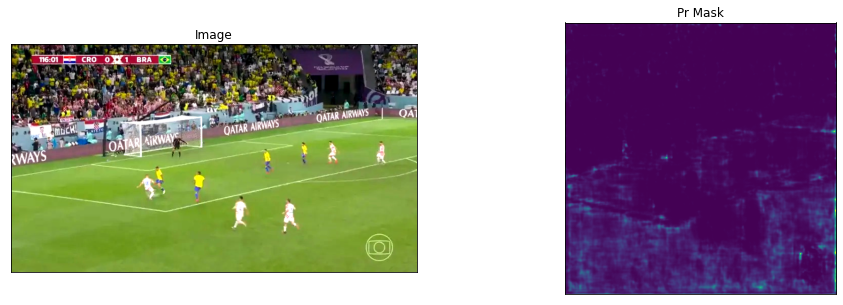

In [56]:
visualize(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask[..., -1].squeeze(),
    )

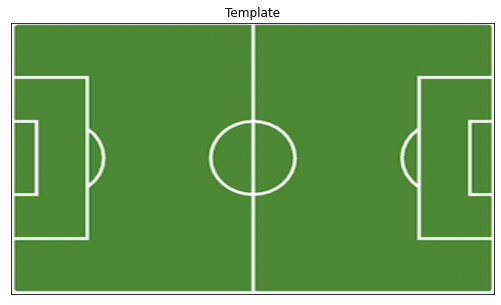

In [48]:
template = cv2.imread('/content/SoccerAlgorithm/world_cup_template.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))/255.
visualize(template=template)


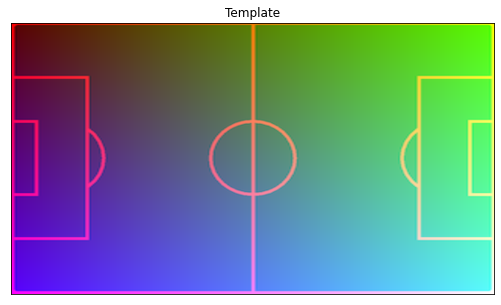

In [49]:
template = rgb_template_to_coord_conv_template(template)
visualize(template=template)

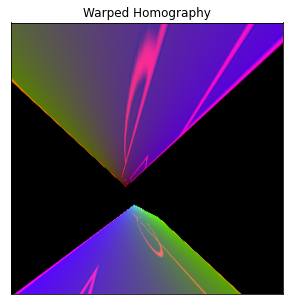

In [50]:
src,dst = _points_from_mask(pr_mask[0])
pred_homo = get_perspective_transform(dst,src)
pred_warp = warp_image(cv2.resize(template, (320,320)),pred_homo,out_shape=(320,320))
visualize(
        warped_homography=pred_warp,
    )

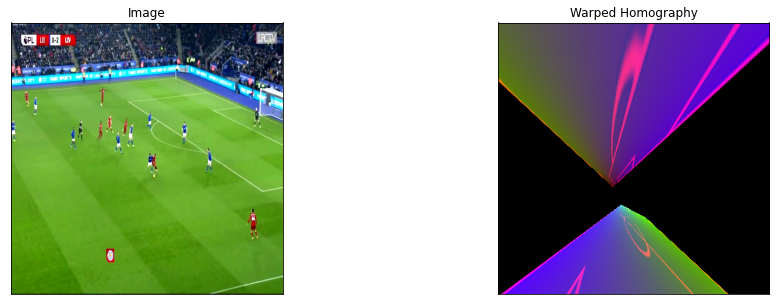

In [51]:
src,dst = _points_from_mask(pr_mask[0])
pred_homo = get_perspective_transform(dst,src)
pred_warp = warp_image(cv2.resize(template, (320,320)),pred_homo,out_shape=(320,320))
visualize(
        image=denormalize(image.squeeze()),
        warped_homography=pred_warp,
    )

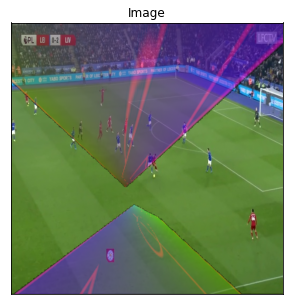

In [52]:
test = merge_template(image/255.,cv2.resize(pred_warp, (image.shape[1],image.shape[0])))
visualize(image = test)